## AI - Prioritized Sweep Algorithm



### Task Description
---
<img style="float:right" src="A4.jpg" alt="drawing" width="500"/>

 > Consider a simple grid shown a map for you to your college for a class. The map is shown on the right. There are four actions, `up`, `down`, `right`, and `left` in each of states. You (like an agent in RL algorithm), take the actions deterministically to the corresponding neighboring states, except when movement is blocked by a building (Green color blocks) or the edge of the map, in which case the you stay where it is. Reward is zero on all transitions (like crossing streets, etc), except those into the goal state, which is the university, on which it is +1. After reaching the goal state `Univ`, you complete one episode, and then begin a new episode from state (location) `You` at (0,0).
 
 In this task, one of implementations of Dyna-Q algorithms, PrioritzedSweepAlgorithm, is implemented based on the models given as the map of your college.
 
 Let's treat this map as a grid. In this particular case (shown on the diagram), there are following properties:
 
 ROWS = 7
 
 COLS = 9
 
 YOU = (0,0)
 
 UNIV = (6,8)
 
 BUILDINGS = [(2, 2), (3, 2), (4, 2), (0, 4), (6,4), (3, 6), (4, 6), (5, 8)]

 ACTIONS = ["left", "up", "right", "down"]
 
---
>




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
ROWS = 7
COLS = 9
YOU = (0,0)
UNIV = (6,8)
BUILDINGS = [(2, 2), (3, 2), (4, 2), (0, 4), (6,4), (3, 6), (4, 6), (5, 8)]
ACTIONS = ["left", "up", "right", "down"]

### Models

In [3]:
class UnivMap:
    """
    This initializes the UnivMap object. The state is a tuple which represents
    the position in the map, which is the row and column. Update the state if 
    both row abd col values in the reasonable range (0 <= r <= ROWS-1, 0<= c <= CLOS-1),
    otherwise, ignore the state value.
    
    """
    def __init__(self, rows=ROWS, cols=COLS, start=YOU, dest=UNIV, buildings=BUILDINGS):
        self.rows = rows
        self.cols = cols
        self.you = start
        self.univ = dest
        self.buildings = buildings
        self.state = start
        self.end = False
        # init univMap
        self.univMap = np.zeros((self.rows, self.cols))
        for b in self.buildings:
            self.univMap[b] = -1
            
    def nxtState(self, action):
        r, c = self.state
        if action == "left":
            c -= 1
        elif action == "right":
            c += 1
        elif action == "up":
            r -= 1
        else:
            r += 1
        
        if (r >= 0 and r <= self.rows-1) and (c >= 0 and c <= self.cols-1):
            if (r, c) not in self.buildings:
                self.state = (r, c)
        return self.state
    
    def giveReward(self):
        if self.state == self.univ:
            self.end = True
            return 1
        else:
            return 0
        
    def showUnivMap(self):
        self.univMap[self.state] = 1
        for i in range(self.rows-1,-1, -1):
            print('-------------------------------------')
            out = '| '
            for j in range(0, self.cols):
                #print(self.univMap[i,j], i, j)
                if self.univMap[i, j] == 1:
                    token = '*'
                if self.univMap[i, j] == -1:
                    token = 'z'
                if self.univMap[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-------------------------------------')

In [4]:
u = UnivMap(ROWS,COLS,YOU,UNIV,BUILDINGS)
u.showUnivMap()

-------------------------------------
| 0 | 0 | 0 | 0 | z | 0 | 0 | 0 | 0 | 
-------------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | z | 
-------------------------------------
| 0 | 0 | z | 0 | 0 | 0 | z | 0 | 0 | 
-------------------------------------
| 0 | 0 | z | 0 | 0 | 0 | z | 0 | 0 | 
-------------------------------------
| 0 | 0 | z | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------
| * | 0 | 0 | 0 | z | 0 | 0 | 0 | 0 | 
-------------------------------------


### Prioritized Sweep Algorithm

In [16]:
from queue import PriorityQueue

In [17]:
class PrioritizedSweep:
    def __init__(self, univMap, n_plannings, episodes=1, alpha=0.1, epsilon = 0.1, gamma = 0.95, theta=0.0, k=0.001):
        self.univMap = univMap
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.theta = theta
        self.actions = ACTIONS
        self.n_plannings = n_plannings
        self.episodes= episodes
        self.model = dict()
        self.Q_values = {}
        
        # maintain a priority queue
        self.priorityQueue = PriorityQueue()
        
        self.state_actions = []  # state & action track
        
        self.k = k
        self.tao_dict = defaultdict(int)
        
        self.model = {}
        for row in range(ROWS-1, -1, -1):
            for col in range(COLS):
                self.Q_values[(row, col)] = {}
                for a in self.actions:
                    self.Q_values[(row, col)][a] = 0

    def bonus(self, state, action):
        return self.k*np.sqrt(self.tao_dict[(state,action)])
    
    def reset(self):
        self.univMap = UnivMap(ROWS,COLS,YOU,UNIV,BUILDINGS)
        self.state = YOU
        self.state_actions = []
        self.priorityQueue = PriorityQueue()
        
    def chooseAction(self):
        # epsilon-greedy
        mx_nxt_reward = -999
        action = ""
        
        if np.random.uniform(0, 1) <= self.alpha:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            current_position = self.state
            # if all actions have same value, then select randomly
            if len(set(self.Q_values[current_position].values())) == 1:
                action = np.random.choice(self.actions)
            else:
                for a in self.actions:
                    nxt_reward = self.Q_values[current_position][a]
                    if nxt_reward >= mx_nxt_reward:
                        action = a
                        mx_nxt_reward = nxt_reward
        for t in self.tao_dict.keys():
            if t != (self.state, action):
                self.tao_dict[t] += 1
        self.tao_dict[(self.state, action)] = 0
        
        return action
    
    # add a @state-@action pair into the priority queue with priority @priority
    def insert(self, priority, state, action):
        self.priorityQueue.put((priority, (state, action)))

    # @return: whether the priority queue is empty
    def empty(self):
        return self.priorityQueue.empty()
    
    def play(self):
        self.steps_per_episode = []  
        
        for ep in range(self.episodes):    
            while not self.univMap.end:
                action = self.chooseAction()
                self.state_actions.append((self.state, action))

                nxtState = self.univMap.nxtState(action)
                reward = self.univMap.giveReward()
                # add bonus reward
                bonus_reward = self.bonus(self.state, action)
                reward += bonus_reward
                
                # update model
                if self.state not in self.model.keys():
                    self.model[self.state] = {}
                self.model[self.state][action] = (reward, nxtState)
                
                # get priority
                priority = np.abs(reward + self.gamma * 
                                  np.max(list(self.Q_values[nxtState].values())) -
                                 self.Q_values[self.state][action])
                
                if priority > self.theta:
                    self.insert(priority, self.state, action)

                # loop n times to randomly update Q-value
                for _ in range(self.n_plannings):
                    # get priority, state, action
                    if self.priorityQueue.qsize() > 0:
                        # get priority state and action
                        priority, (state, action) = self.priorityQueue.get()
                        # get the retuen value from the model, reward and newState
                        reward, newState = self.model[state][action]
                        # update Q value
                        self.Q_values[state][action] += self.gamma*(reward + np.max(list(self.Q_values[newState].values())) 
                                                             - self.Q_values[state][action])
                        
                        # iterate through all previous state-action pairs
                        for _state, _action in self.state_actions:
                            _reward, _newState = self.model[_state][_action]
                            priority = np.abs(_reward + self.gamma * 
                                  np.max(list(self.Q_values[_newState].values())) -
                                 self.Q_values[_state][_action])
                            # update priority queue
                            if priority > self.theta:
                                self.insert(priority, _state, _action)
                
                self.state = nxtState
            # end of game
            if ep % 10 == 0:
                print("episode", ep)
            self.steps_per_episode.append(len(self.state_actions))
            self.reset()

In [18]:
student_p = PrioritizedSweep(u, n_plannings=1, episodes=N_EPISODES)

In [19]:
student_p.play()

steps_episode_0_p = student_p.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


In [20]:
student_p = PrioritizedSweep(u, n_plannings=5, episodes=N_EPISODES)
student_p.play()

steps_episode_5_p = student_p.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


In [21]:
student_p = PrioritizedSweep(u, n_plannings=50, episodes=N_EPISODES)
student_p.play()

steps_episode_50_p = student_p.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


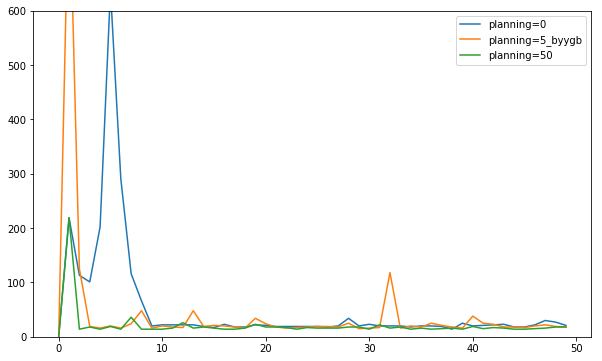

In [23]:
plt.figure(figsize=[10, 6])

plt.ylim(0, 600)
plt.plot(range(N_EPISODES), steps_episode_0_p, label="planning=0")
plt.plot(range(N_EPISODES), steps_episode_5_p, label="planning=5_byygb")
plt.plot(range(N_EPISODES), steps_episode_50_p, label="planning=50")

plt.legend()